In [1]:
#импорт необходимых библиотек
import pandas as pd
import os as os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib
import numpy as np

import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report, precision_score, recall_score, f1_score,accuracy_score,roc_auc_score

**Обработка данных**

In [3]:
file_path = os.path.join('../BKP_GIT/data/source/Airline_new.csv')# Загрузка данных из CSV файла
airline = pd.read_csv(file_path)
airline.head(5)# Демонстрация первых нескольких строк

,Aircraft,AirlineName,CabinType,DateFlown,DatePub,EntertainmentRating,FoodRating,GroundServiceRating,OriginCountry,OverallScore,...,Route,SeatComfortRating,ServiceRating,Slug,Title,TravelType,TripVerified,ValueRating,WifiRating,unique_id
0,NaN,AB Aviation,Economy Class,November 2019,11th November 2019,0,4,4,Netherlands,9.0,...,Moroni to Moheli,4,5,ab-aviation,pretty decent airline,Solo Leisure,Trip Verified,3,0,d3b260fb-268b-4399-8a9b-2804825902c6
1,E120,AB Aviation,Economy Class,June 2019,25th June 2019,0,1,1,UnitedKingdom,1.0,...,Moroni to Anjouan,2,2,ab-aviation,Not a good airline,Solo Leisure,Trip Verified,2,0,307711df-268f-4698-97b8-45729b7d972e
2,Embraer E120,AB Aviation,Economy Class,June 2019,25th June 2019,0,1,1,UnitedKingdom,1.0,...,Anjouan to Dzaoudzi,2,1,ab-aviation,flight was fortunately short,Solo Leisure,Trip Verified,2,0,82bd2602-171d-4724-bde0-90b71621cdcf
3,NaN,Aerocaribbean,Economy Class,NaN,31st December 2010,0,0,0,Denmark,8.0,...,NaN,0,0,aerocaribbean,Aerocaribbean customer review,NaN,NaN,4,0,a927beb4-6244-4f5c-9dc3-09890aa3e616
4,NaN,Aerocaribbean,NaN,NaN,25th November 2010,0,0,0,UnitedKingdom,1.0,...,NaN,0,0,aerocaribbean,Aerocaribbean customer review,NaN,NaN,0,0,d7bea425-c58a-4a7e-8269-02e0e6516633


C:\ProgramData\anaconda3\Lib\site-packages\missingno\missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  warnings.warn(


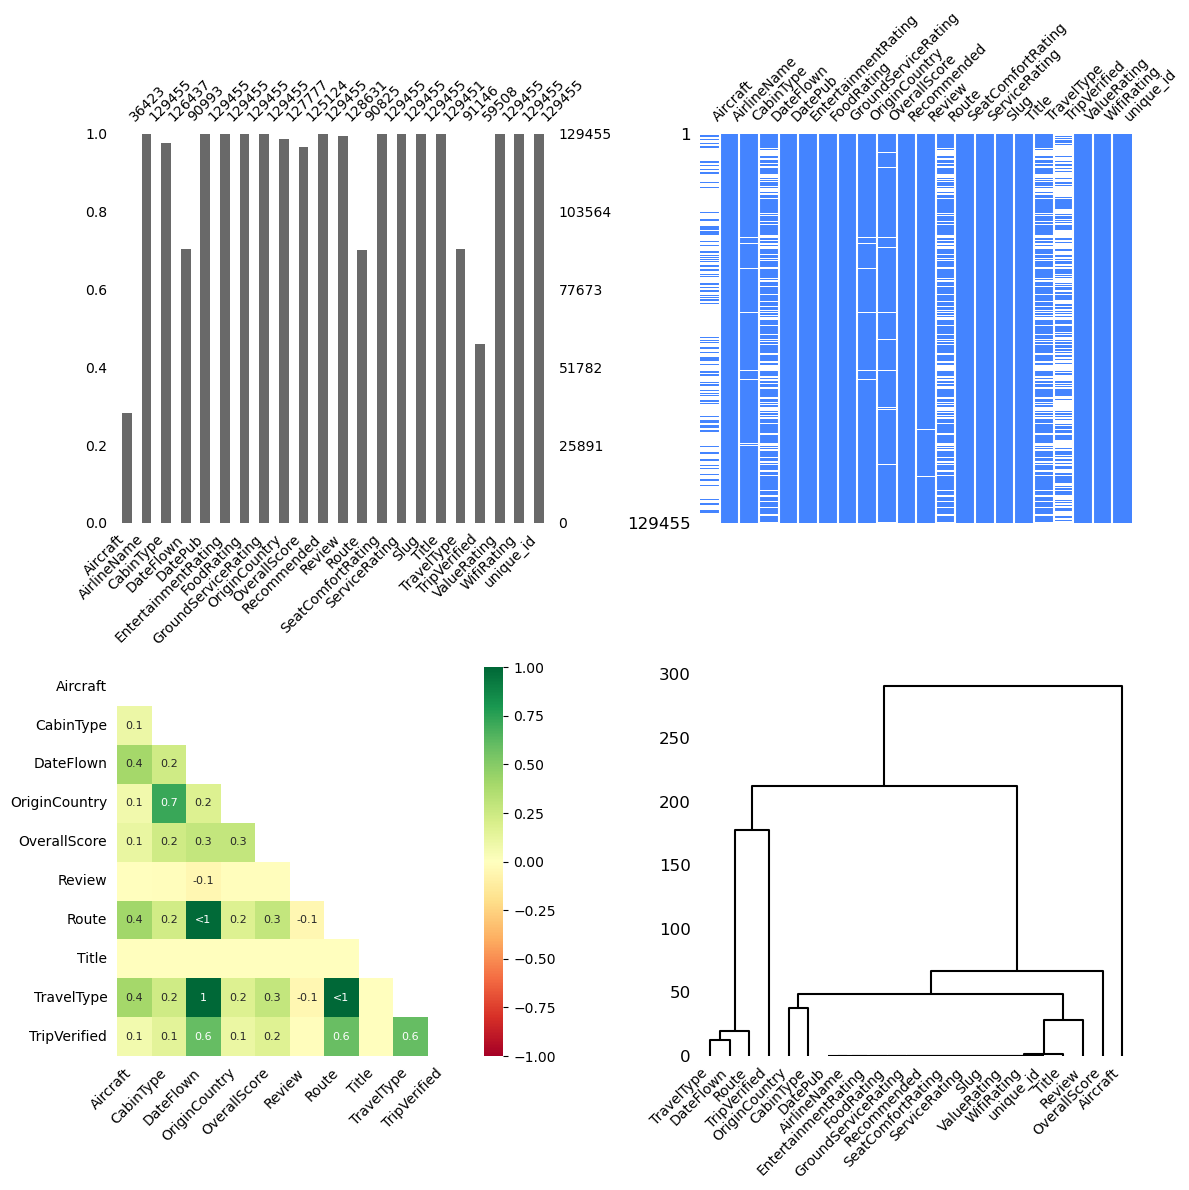

In [4]:
#Диаграмма, матрица, тепловая карта и дендограмма пропущенных значений на исходном наборе данных
fig = plt.figure(figsize=(12,12))

ax1 = fig.add_subplot(2,2,1)
msno.bar(airline,fontsize=10,figsize=(6,6),ax=ax1)
ax2 = fig.add_subplot(2,2,2)
msno.matrix(airline,fontsize=10,figsize=(6,6),color=(0.27, 0.52, 1.0),ax=ax2)
ax3 = fig.add_subplot(2,2,3)
msno.heatmap(airline,fontsize=10,figsize=(6,6),cmap="RdYlGn",ax=ax3)
ax4 = fig.add_subplot(2,2,4)
msno.dendrogram(airline,fontsize=10,figsize=(6,6),orientation="top",ax=ax4)

plt.tight_layout()

**Удаление ненужных признаков из набора данных, так как они не будут использованы в дальнешей работе**

In [6]:
columns_to_drop = ['Aircraft', 'AirlineName', 'DateFlown' ,'DatePub', 'Route', 'Slug', 'Title', 'TripVerified', 'unique_id']# Удаление ненужных столбцов
data = airline.drop(columns=columns_to_drop)
data.head(5)

,CabinType,EntertainmentRating,FoodRating,GroundServiceRating,OriginCountry,OverallScore,Recommended,Review,SeatComfortRating,ServiceRating,TravelType,ValueRating,WifiRating
0,Economy Class,0,4,4,Netherlands,9.0,yes,Moroni to Moheli. Turned out to be a pretty de...,4,5,Solo Leisure,3,0
1,Economy Class,0,1,1,UnitedKingdom,1.0,no,Moroni to Anjouan. It is a very small airline....,2,2,Solo Leisure,2,0
2,Economy Class,0,1,1,UnitedKingdom,1.0,no,Anjouan to Dzaoudzi. A very small airline and ...,2,1,Solo Leisure,2,0
3,Economy Class,0,0,0,Denmark,8.0,yes,Havana - Cayo Coco return. A one hour flight w...,0,0,NaN,4,0
4,NaN,0,0,0,UnitedKingdom,1.0,no,Holguin to Havana last week. Okay apart from i...,0,0,NaN,0,0


In [7]:
data.describe()

,EntertainmentRating,FoodRating,GroundServiceRating,OverallScore,SeatComfortRating,ServiceRating,ValueRating,WifiRating
count,129455.000000,129455.000000,129455.000000,125124.000000,129455.000000,129455.000000,129455.000000,129455.000000
mean,1.557190,1.989077,1.652010,4.556408,2.470202,2.689622,2.637527,0.453926
std,1.751076,1.774512,1.740252,3.498833,1.620262,1.774499,1.628808,1.078274
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
50%,1.000000,1.000000,1.000000,3.000000,2.000000,3.000000,2.000000,0.000000
75%,3.000000,4.000000,3.000000,8.000000,4.000000,4.000000,4.000000,0.000000
max,5.000000,5.000000,5.000000,10.000000,5.000000,5.000000,5.000000,5.000000


In [8]:
data.info() #количество ненулевых значений

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129455 entries, 0 to 129454
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   CabinType            126437 non-null  object 
 1   EntertainmentRating  129455 non-null  int64  
 2   FoodRating           129455 non-null  int64  
 3   GroundServiceRating  129455 non-null  int64  
 4   OriginCountry        127777 non-null  object 
 5   OverallScore         125124 non-null  float64
 6   Recommended          129455 non-null  object 
 7   Review               128631 non-null  object 
 8   SeatComfortRating    129455 non-null  int64  
 9   ServiceRating        129455 non-null  int64  
 10  TravelType           91146 non-null   object 
 11  ValueRating          129455 non-null  int64  
 12  WifiRating           129455 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 12.8+ MB


In [9]:
data.describe(include=[object])

,CabinType,OriginCountry,Recommended,Review,TravelType
count,126437,127777,129455,128631,91146
unique,4,202,2,128425,4
top,Economy Class,UnitedStates,no,My wife and I just got back from a 13-day trip...,Solo Leisure
freq,102735,39807,77597,2,33246


In [10]:
data.describe(include=[float])

,OverallScore
count,125124.000000
mean,4.556408
std,3.498833
min,1.000000
25%,1.000000
50%,3.000000
75%,8.000000
max,10.000000


**В признаке "Общий рейтинг" исправим значение "n" на 10**

In [12]:
data['OverallScore'].unique()

array([ 9.,  1.,  8.,  2.,  3., 10.,  5.,  6.,  7.,  4., nan])

In [13]:
data['OverallScore']=data['OverallScore'].fillna(10).astype(int)

In [14]:
data['OverallScore'].value_counts(normalize=True)

OverallScore
1     0.340427
10    0.146097
9     0.096651
2     0.094458
8     0.090796
3     0.060013
7     0.058623
5     0.041682
4     0.037171
6     0.034081
Name: proportion, dtype: float64

In [15]:
data['TravelType'].value_counts(normalize=True)

TravelType
Solo Leisure      0.364755
Couple Leisure    0.261613
Family Leisure    0.218331
Business          0.155300
Name: proportion, dtype: float64

In [16]:
data['CabinType'].value_counts(normalize=True)

CabinType
Economy Class      0.812539
Business Class     0.130294
Premium Economy    0.038090
First Class        0.019077
Name: proportion, dtype: float64

In [17]:
data['Recommended'].value_counts(normalize=True)

Recommended
no     0.599413
yes    0.400587
Name: proportion, dtype: float64

In [18]:
data['EntertainmentRating'].value_counts(normalize=True)

EntertainmentRating
0    0.418060
1    0.208358
4    0.108694
3    0.102947
5    0.093778
2    0.068163
Name: proportion, dtype: float64

In [19]:
data['FoodRating'].value_counts(normalize=True)

FoodRating
0    0.280514
1    0.229261
4    0.139384
3    0.130833
5    0.123255
2    0.096752
Name: proportion, dtype: float64

In [20]:
data['GroundServiceRating'].value_counts(normalize=True)

GroundServiceRating
1    0.328577
0    0.321726
5    0.119941
4    0.095191
3    0.073833
2    0.060732
Name: proportion, dtype: float64

In [21]:
data['SeatComfortRating'].value_counts(normalize=True)

SeatComfortRating
1    0.263250
4    0.186528
3    0.176826
5    0.135151
2    0.127303
0    0.110942
Name: proportion, dtype: float64

In [22]:
data['ServiceRating'].value_counts(normalize=True)

ServiceRating
1    0.252319
5    0.241922
4    0.153745
3    0.132393
0    0.111854
2    0.107767
Name: proportion, dtype: float64

In [23]:
data['ValueRating'].value_counts(normalize=True)

ValueRating
1    0.383685
5    0.199714
4    0.172925
3    0.113020
2    0.112255
0    0.018400
Name: proportion, dtype: float64

In [24]:
data['WifiRating'].value_counts(normalize=True)

WifiRating
0    0.772299
1    0.139099
5    0.024418
3    0.023784
4    0.020293
2    0.020107
Name: proportion, dtype: float64

C:\ProgramData\anaconda3\Lib\site-packages\missingno\missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  warnings.warn(


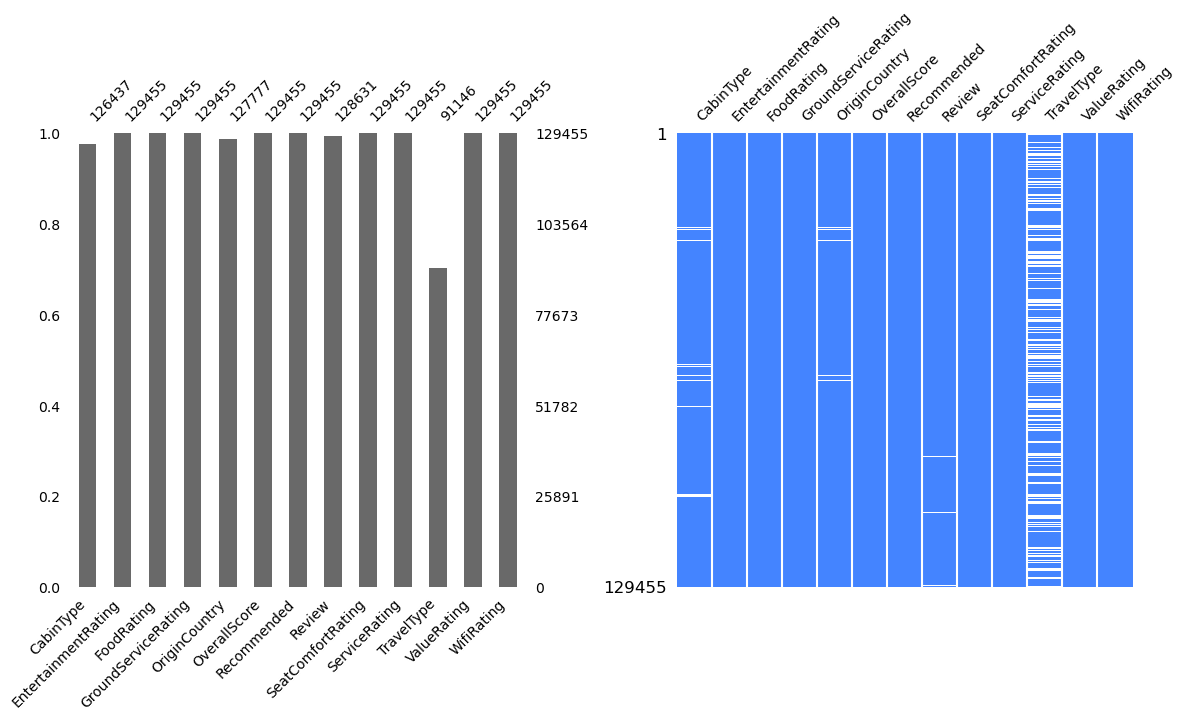

In [25]:
fig = plt.figure(figsize=(12,12))

ax1 = fig.add_subplot(2,2,1)
msno.bar(data,fontsize=10,figsize=(6,6),ax=ax1)
ax2 = fig.add_subplot(2,2,2)
msno.matrix(data,fontsize=10,figsize=(6,6),color=(0.27, 0.52, 1.0),ax=ax2)

plt.tight_layout()

**Обработка пропущенных значений**

In [27]:
data.isnull().sum() #количество пропущенных зачений

CabinType               3018
EntertainmentRating        0
FoodRating                 0
GroundServiceRating        0
OriginCountry           1678
OverallScore               0
Recommended                0
Review                   824
SeatComfortRating          0
ServiceRating              0
TravelType             38309
ValueRating                0
WifiRating                 0
dtype: int64

In [28]:
non_null_values = data['CabinType'].dropna()
data['CabinType'] = data['CabinType'].apply(
    lambda x: np.random.choice(non_null_values) if pd.isna(x) else x
)

In [29]:
non_null_values = data['TravelType'].dropna()
data['TravelType'] = data['TravelType'].apply(
    lambda x: np.random.choice(non_null_values) if pd.isna(x) else x
)

In [30]:
methods = {'OriginCountry': 'mode', 'Review': 'mode'}

def fill_na(column):
    method = methods.get(column.name)
    if method == 'mode':
        return column.fillna(column.mode()[0])
    return column

data = data.apply(fill_na)
data.head(5)

,CabinType,EntertainmentRating,FoodRating,GroundServiceRating,OriginCountry,OverallScore,Recommended,Review,SeatComfortRating,ServiceRating,TravelType,ValueRating,WifiRating
0,Economy Class,0,4,4,Netherlands,9,yes,Moroni to Moheli. Turned out to be a pretty de...,4,5,Solo Leisure,3,0
1,Economy Class,0,1,1,UnitedKingdom,1,no,Moroni to Anjouan. It is a very small airline....,2,2,Solo Leisure,2,0
2,Economy Class,0,1,1,UnitedKingdom,1,no,Anjouan to Dzaoudzi. A very small airline and ...,2,1,Solo Leisure,2,0
3,Economy Class,0,0,0,Denmark,8,yes,Havana - Cayo Coco return. A one hour flight w...,0,0,Couple Leisure,4,0
4,Business Class,0,0,0,UnitedKingdom,1,no,Holguin to Havana last week. Okay apart from i...,0,0,Couple Leisure,0,0


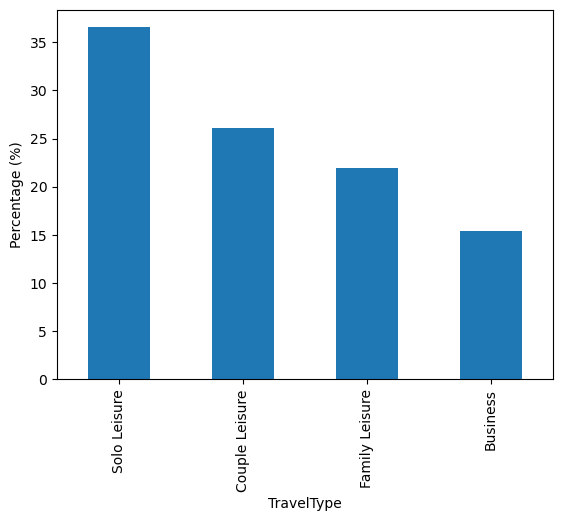

In [31]:
ax = data['TravelType'].value_counts(normalize=True).mul(100).plot(kind='bar')
ax.set_ylabel('Percentage (%)')
plt.show()

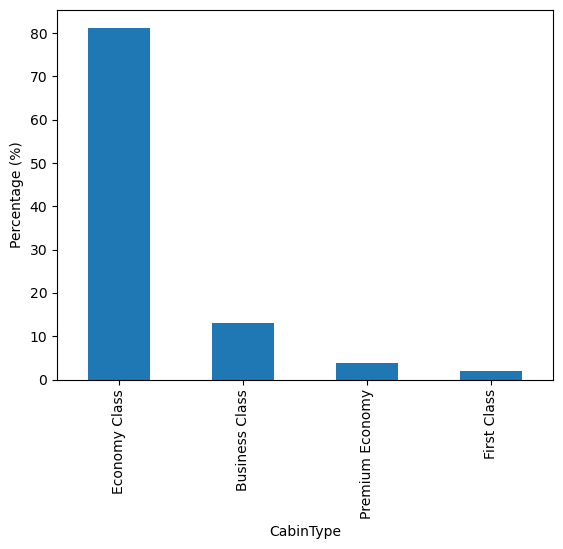

In [32]:
ax = data['CabinType'].value_counts(normalize=True).mul(100).plot(kind='bar')
ax.set_ylabel('Percentage (%)')
plt.show()

Вопрос сбалансированности данных. Думаю, надо использовать другие методы заполнения пропущенных значений, чтобы категориальные даные были более сбалансированны.

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129455 entries, 0 to 129454
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   CabinType            129455 non-null  object
 1   EntertainmentRating  129455 non-null  int64 
 2   FoodRating           129455 non-null  int64 
 3   GroundServiceRating  129455 non-null  int64 
 4   OriginCountry        129455 non-null  object
 5   OverallScore         129455 non-null  int32 
 6   Recommended          129455 non-null  object
 7   Review               129455 non-null  object
 8   SeatComfortRating    129455 non-null  int64 
 9   ServiceRating        129455 non-null  int64 
 10  TravelType           129455 non-null  object
 11  ValueRating          129455 non-null  int64 
 12  WifiRating           129455 non-null  int64 
dtypes: int32(1), int64(7), object(5)
memory usage: 12.3+ MB


**Предварительный анализ данных**

Создаем новый признак с NPS каждого клиента, чтобы упростить расчет общего NPS. (NPS - это показатель, используемый для оценки лояльности и удовлетворенности клиентов в компании, который рассчитывается путем задания клиентам одного вопроса: “По шкале от 0 до 10, насколько вероятно, что вы порекомендуете этот продукт / компанию другу или коллеге?”)

In [37]:
def define_profile(score):
    if score <= 6:
        return 'Detractor'
    elif score <= 8:
        return 'Passive'
    else:
        return 'Promoter'

data['Profile'] = data['OverallScore'].apply(define_profile)
data.to_csv('../BKP_GIT/data/airlines_ready_binary.csv', index=False)

**Расчет процентного соотношения категорий по "Типу места"**

In [39]:
profile_percentage = data.groupby(['CabinType', 'Profile']).size() / data.groupby('CabinType').size() * 100
profile_percentage = profile_percentage.unstack().fillna(0)

Определение цвета для каждой категории

In [41]:
colors = {'Promoter': 'green', 'Passive': 'yellow', 'Detractor': 'red'}

Построение столбчатой диаграммы. Отображение условных обозначений. Добавление меток с процентными значениями поверх столбцов.

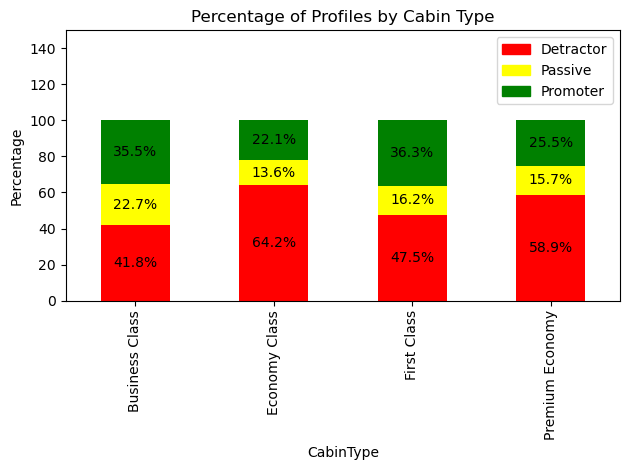

In [43]:
ax = profile_percentage.plot(kind='bar', stacked=True, color=[colors[col] for col in profile_percentage.columns])

plt.xlabel('CabinType')
plt.ylabel('Percentage')
plt.title('Percentage of Profiles by Cabin Type')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=[plt.Rectangle((0, 0), 1, 1, color=colors[label]) for label in labels], labels=labels)

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='center', fontsize=10, color='black')

plt.ylim(0, 150)
plt.tight_layout()
plt.show()

Рекомендуют ли клиенты компанию, в зависимости от "Типа места"

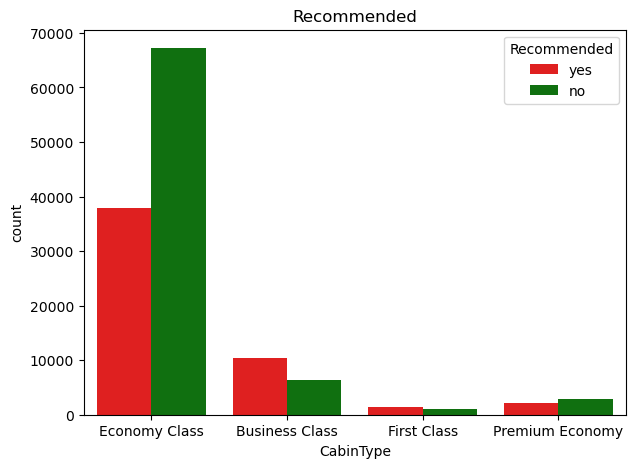

In [45]:
data.groupby(["Recommended","CabinType"])["Recommended"].count()
fig, axs = plt.subplots(figsize=(7, 5))
axs = sns.countplot(x='CabinType',hue='Recommended',data=data,palette=["red","green"]).set_title('Recommended')

Тест 3 моделей машинного обучения для этого набора данных - Случайный лес, XGBoost, LightGBM

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129455 entries, 0 to 129454
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   CabinType            129455 non-null  object
 1   EntertainmentRating  129455 non-null  int64 
 2   FoodRating           129455 non-null  int64 
 3   GroundServiceRating  129455 non-null  int64 
 4   OriginCountry        129455 non-null  object
 5   OverallScore         129455 non-null  int32 
 6   Recommended          129455 non-null  object
 7   Review               129455 non-null  object
 8   SeatComfortRating    129455 non-null  int64 
 9   ServiceRating        129455 non-null  int64 
 10  TravelType           129455 non-null  object
 11  ValueRating          129455 non-null  int64 
 12  WifiRating           129455 non-null  int64 
 13  Profile              129455 non-null  object
dtypes: int32(1), int64(7), object(6)
memory usage: 13.3+ MB


In [48]:
data['Recommended'] = data['Recommended'].map({'yes': 1, 'no': 0})

In [49]:
x = data[['EntertainmentRating',
          'FoodRating',
          'GroundServiceRating', 
          'SeatComfortRating',
          'ServiceRating', 
          'ValueRating',
          'WifiRating']]  # Признаки
y = data['Recommended']                               # Целевая переменная

In [50]:
x_train,x_test,y_train,y_test = train_test_split(x,y,train_size=0.30)

              precision    recall  f1-score   support

           0       0.95      0.95      0.95     54295
           1       0.92      0.92      0.92     36324

    accuracy                           0.94     90619
   macro avg       0.93      0.93      0.93     90619
weighted avg       0.94      0.94      0.94     90619



Text(0.5, 1.0, 'Accuracy Score 0.94')

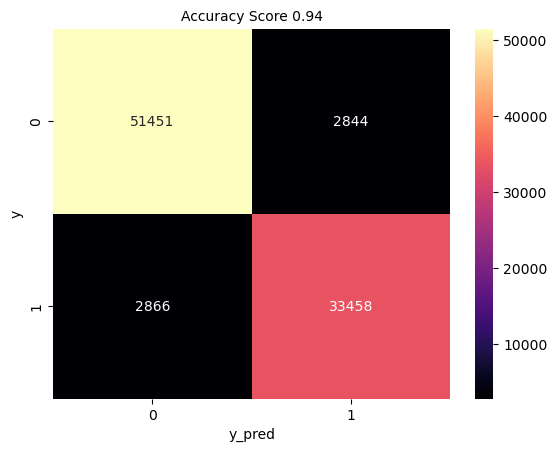

In [51]:
# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(x_train,y_train)

y_pred = rf_model.predict(x_test)
accuracy_score(y_pred,y_test)

cm = confusion_matrix(y_pred,y_test)
acc = round(accuracy_score(y_pred,y_test),2)

print(classification_report(y_pred,y_test))

sns.heatmap(cm,annot=True, fmt=".0f",cmap = 'magma')
plt.xlabel("y_pred")
plt.ylabel("y")
plt.title(f"Accuracy Score {acc}",size=10)

              precision    recall  f1-score   support

           0       0.95      0.95      0.95     54142
           1       0.93      0.93      0.93     36477

    accuracy                           0.94     90619
   macro avg       0.94      0.94      0.94     90619
weighted avg       0.94      0.94      0.94     90619



Text(0.5, 1.0, 'Accuracy Score 0.94')

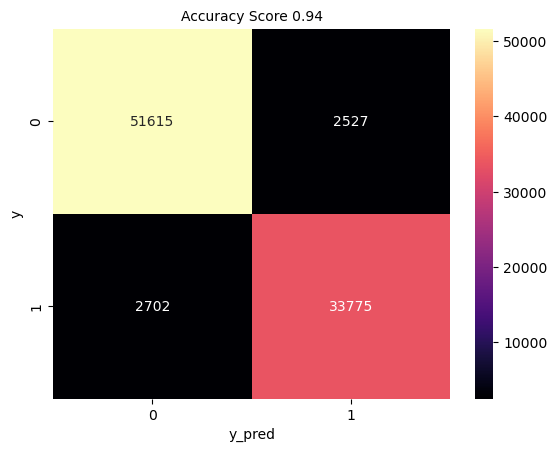

In [52]:
# XGBoost
xgboost_model = XGBClassifier()
xgboost_model.fit(x_train,y_train)

y_pred = xgboost_model.predict(x_test)
accuracy_score(y_pred,y_test)

cm = confusion_matrix(y_pred,y_test)
acc = round(accuracy_score(y_pred,y_test),2)

print(classification_report(y_pred,y_test))

sns.heatmap(cm,annot=True, fmt=".0f",cmap = 'magma')
plt.xlabel("y_pred")
plt.ylabel("y")
plt.title(f"Accuracy Score {acc}",size=10)

              precision    recall  f1-score   support

           0       0.95      0.95      0.95     54080
           1       0.93      0.93      0.93     36539

    accuracy                           0.94     90619
   macro avg       0.94      0.94      0.94     90619
weighted avg       0.94      0.94      0.94     90619



Text(0.5, 1.0, 'Accuracy Score 0.94')

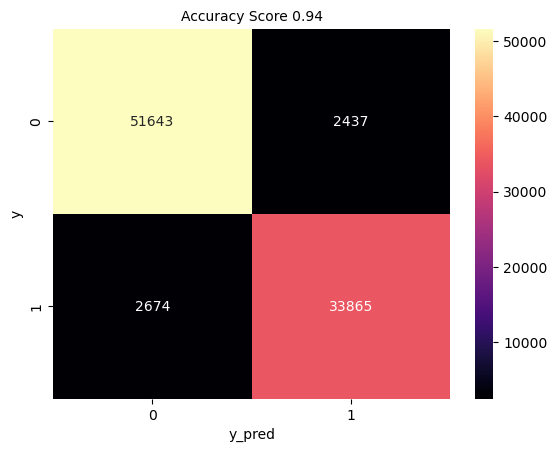

In [53]:
# LightGBM

lgb_model = lgb.LGBMClassifier(verbose=-1)
lgb_model.fit(x_train,y_train)

y_pred = lgb_model.predict(x_test)
accuracy_score(y_pred,y_test) # 0.963

cm = confusion_matrix(y_pred,y_test)
acc = round(accuracy_score(y_pred,y_test),2)

print(classification_report(y_pred,y_test))


sns.heatmap(cm,annot=True, fmt=".0f",cmap = 'magma')
plt.xlabel("y_pred")
plt.ylabel("y")
plt.title(f"Accuracy Score {acc}",size=10)

**Оптимизация моделей**

In [55]:
# RandomForestClassifier

rf_model = RandomForestClassifier()
rf_params = {"max_depth":[5,8],
             "max_features":[4,8,"auto"],
             "min_samples_split":[2,5,8],
             "n_estimators":[100,200,500]}

rf_best_grid = GridSearchCV(rf_model,rf_params,cv=5,n_jobs=-1,verbose=True).fit(x_train,y_train)
rf_best_grid.best_params_

Fitting 5 folds for each of 54 candidates, totalling 270 fits


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
90 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\ProgramData\anaconda3\Lib\site-packages

{'max_depth': 8,
 'max_features': 8,
 'min_samples_split': 8,
 'n_estimators': 100}

In [56]:
rf_final = RandomForestClassifier().set_params(**rf_best_grid.best_params_).fit(x_train,y_train)
y_pred = rf_final.predict(x_test)

print(f"Accuracy:  {(accuracy_score(y_pred, y_test)):.2f}\nPrecision: \
{(precision_score(y_pred, y_test)):.2f}\nRecall:    \
{(recall_score(y_pred, y_test)):.2f}\nF1 score:  \
{(f1_score(y_pred, y_test)):.2f}\nROC:       \
{(roc_auc_score(y_pred, y_test)):.2f}")

Accuracy:  0.94
Precision: 0.93
Recall:    0.93
F1 score:  0.93
ROC:       0.94


In [57]:
# XGBoost
xgboost_model = XGBClassifier()
xgboost_params = {"max_depth":[5,6],
             "learning_rate":[0.1,0.01],
             "colsample_bytree":[0.7,1],
             "n_estimators":[100,200,500]}

xgboost_best_grid = GridSearchCV(xgboost_model,xgboost_params,cv=5,n_jobs=-1,verbose=True).fit(x_train,y_train)
xgboost_best_grid.best_params_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


{'colsample_bytree': 0.7,
 'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 100}

In [58]:
xgboost_final = XGBClassifier().set_params(**xgboost_best_grid.best_params_).fit(x_train,y_train)
y_pred = xgboost_final.predict(x_test)

print(f"Accuracy:  {(accuracy_score(y_pred, y_test)):.2f}\nPrecision: \
{(precision_score(y_pred, y_test)):.2f}\nRecall:    \
{(recall_score(y_pred, y_test)):.2f}\nF1 score:  \
{(f1_score(y_pred, y_test)):.2f}\nROC:       \
{(roc_auc_score(y_pred, y_test)):.2f}")

Accuracy:  0.94
Precision: 0.93
Recall:    0.93
F1 score:  0.93
ROC:       0.94


In [59]:
# LightGBM
lgb_model = lgb.LGBMClassifier(verbose=-1)
lgbm_params = {"learning_rate":[0.1,0.01],
             "colsample_bytree":[0.7,1],
             "n_estimators":[100,200,500]
               }

lgbm_best_grid = GridSearchCV(lgb_model,lgbm_params,cv=5,n_jobs=-1,verbose=0).fit(x_train,y_train)
lgbm_best_grid.best_params_

{'colsample_bytree': 0.7, 'learning_rate': 0.01, 'n_estimators': 500}

In [60]:
lgbm_final = lgb.LGBMClassifier(verbose=-1).set_params(**lgbm_best_grid.best_params_).fit(x,y)
y_pred = lgbm_final.predict(x_test)

print(f"Accuracy:  {(accuracy_score(y_pred, y_test)):.2f}\nPrecision: \
{(precision_score(y_pred, y_test)):.2f}\nRecall:    \
{(recall_score(y_pred, y_test)):.2f}\nF1 score:  \
{(f1_score(y_pred, y_test)):.2f}\nROC:       \
{(roc_auc_score(y_pred, y_test)):.2f}")

Accuracy:  0.95
Precision: 0.93
Recall:    0.93
F1 score:  0.93
ROC:       0.94


**Важность признаков**

In [62]:
rf_feature_imp = pd.DataFrame({"Value":rf_final.feature_importances_, "Feature":x_train.columns})
xgb_feature_imp = pd.DataFrame({"Value":xgboost_final.feature_importances_, "Feature":x_train.columns})
lgb_feature_imp = pd.DataFrame({"Value":lgbm_final.feature_importances_, "Feature":x_train.columns})

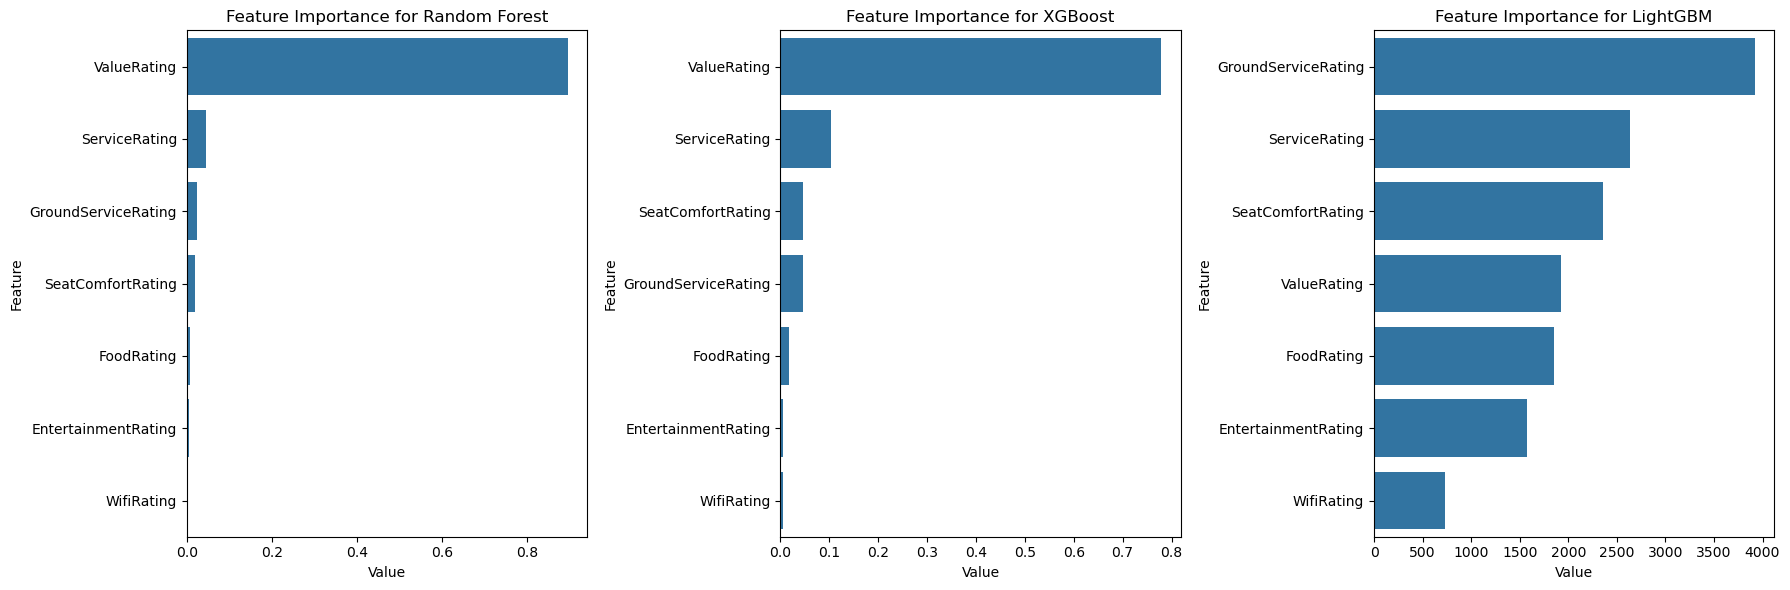

In [63]:
fig, axs = plt.subplots(1,3,figsize=(18,6))

sns.barplot(x="Value",y="Feature",data=rf_feature_imp.sort_values(by="Value",ascending=False)[0:len(x_train)],ax=axs[0])
axs[0].set_title('Feature Importance for Random Forest')
sns.barplot(x="Value",y="Feature",data=xgb_feature_imp.sort_values(by="Value",ascending=False)[0:len(x_train)],ax=axs[1])
axs[1].set_title('Feature Importance for XGBoost')
sns.barplot(x="Value",y="Feature",data=lgb_feature_imp.sort_values(by="Value",ascending=False)[0:len(x_train)],ax=axs[2])
axs[2].set_title('Feature Importance for LightGBM')
plt.tight_layout()

In [64]:
classifiers = [("RandomForestClassifier",RandomForestClassifier(),RandomForestClassifier(max_depth= 8,max_features=8,min_samples_split= 5,n_estimators=100)),
               ("XGBClassifier",XGBClassifier(),XGBClassifier(colsample_bytree= 0.7,learning_rate=0.1,max_depth= 5,n_estimators=100)),
               ("LGBMClassifier",lgb.LGBMClassifier(verbose=-1),lgb.LGBMClassifier(colsample_bytree= 0.7,learning_rate=0.1,n_estimators=100,verbose=-1))]

In [65]:
def calculate(y):
    acc = accuracy_score(y,y_test)
    pre = precision_score(y,y_test)
    rec = recall_score(y,y_test)
    f1 = f1_score(y,y_test)
    auc = roc_auc_score(y,y_test)
    return acc,pre,rec,f1,auc

In [66]:
def model_call(x_train, x_test, y_train, y_test,mod_opt,plot=False):

    pl= []
    i = 0
    if mod_opt == False:
        for name,mod1,mod2 in classifiers:

            model = mod1.fit(x_train, y_train)
            y_pred = model.predict(x_test)
            acc,pre,rec,f1,auc = calculate(y_pred)
            pl.append([acc,pre,rec,f1,auc])

            print(f"{name.upper()}\nBefore: Accuracy: {pl[i][0]} Precision: {pl[i][1]} Recall: {pl[i][2]} F1 score: {pl[i][3]} ROC:{pl[i][4]}\n")
            i = i + 1
    pl2 = []
    if mod_opt:

        for name,mod1,mod2 in classifiers:
            model = mod1.fit(x_train, y_train)
            y_pred = model.predict(x_test)
            acc,pre,rec,f1,auc = calculate(y_pred)
            pl.append([acc,pre,rec,f1,auc])

            final = mod2.fit(x_train,y_train)
            y_pred_final = final.predict(x_test)
            acc,pre,rec,f1,auc = calculate(y_pred_final)
            pl2.append([acc,pre,rec,f1,auc])

            print(f"{name.upper()}\nBefore: Accuracy: {pl[i][0]:.3f} Precision: {pl[i][1]:.3f} Recall: {pl[i][2]:.3f} F1 score: {pl[i][3]:.3f} ROC:{pl[i][4]:.3f}\nAfter:  Accuracy: {pl2[i][0]:.3f} Precision: {pl2[i][1]:.3f} Recall: {pl2[i][2]:.3f} F1 score: {pl2[i][3]:.3f} ROC:{pl2[i][4]:.3f}\n")

            print(f"{name.upper()}\nBefore: Accuracy: {pl[i][0]:.2f} Precision: {pl[i][1]:.2f} Recall: {pl[i][2]:.2f} F1 score: {pl[i][3]:.2f} ROC:{pl[i][4]:.2f}\nAfter:  Accuracy: {pl2[i][0]:.2f} Precision: {pl2[i][1]:.2f} Recall: {pl2[i][2]:.2f} F1 score: {pl2[i][3]:.2f} ROC:{pl2[i][4]:.2f}\n")

            i = i + 1

    if plot:
        plot_importance(model, x_train)
        plot_importance(final, x_train)


model_call(x_train, x_test, y_train, y_test,mod_opt=True)

RANDOMFORESTCLASSIFIER
Before: Accuracy: 0.937 Precision: 0.923 Recall: 0.921 F1 score: 0.922 ROC:0.935
After:  Accuracy: 0.943 Precision: 0.931 Recall: 0.928 F1 score: 0.930 ROC:0.941

RANDOMFORESTCLASSIFIER
Before: Accuracy: 0.94 Precision: 0.92 Recall: 0.92 F1 score: 0.92 ROC:0.93
After:  Accuracy: 0.94 Precision: 0.93 Recall: 0.93 F1 score: 0.93 ROC:0.94

XGBCLASSIFIER
Before: Accuracy: 0.942 Precision: 0.930 Recall: 0.926 F1 score: 0.928 ROC:0.940
After:  Accuracy: 0.945 Precision: 0.933 Recall: 0.929 F1 score: 0.931 ROC:0.942

XGBCLASSIFIER
Before: Accuracy: 0.94 Precision: 0.93 Recall: 0.93 F1 score: 0.93 ROC:0.94
After:  Accuracy: 0.94 Precision: 0.93 Recall: 0.93 F1 score: 0.93 ROC:0.94

LGBMCLASSIFIER
Before: Accuracy: 0.944 Precision: 0.933 Recall: 0.927 F1 score: 0.930 ROC:0.941
After:  Accuracy: 0.945 Precision: 0.932 Recall: 0.930 F1 score: 0.931 ROC:0.942

LGBMCLASSIFIER
Before: Accuracy: 0.94 Precision: 0.93 Recall: 0.93 F1 score: 0.93 ROC:0.94
After:  Accuracy: 0.94 Pr

In [67]:
lgbm_final.booster_.save_model('../BKP_GIT/model/lgbm_model_binary.txt')#сохраняем модель
loaded_model = lgb.Booster(model_file = '../BKP_GIT/model/lgbm_model_binary.txt')